In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pymc
from pomegranate import BayesianNetwork
#os.chdir('C:\Users\SYARLAG1\Desktop\Income-Prediction-Using-Bayes-Net')
os.chdir('/Users/Sriram/Desktop/DePaul/Q5/CSC529/Income-Prediction-Using-Bayes-Net')

Populating the interactive namespace from numpy and matplotlib


In [2]:
features = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',\
           'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class']
train = pd.read_csv('train.csv',delimiter=',',names=features,na_values=[' ?'])
test = pd.read_csv('test.csv',delimiter=',', names=features,na_values=[' ?'])

In [3]:
train.shape 

(32561, 15)

In [4]:
test.shape

(16281, 15)

In [5]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Preprocessing

In [6]:
# for some reason test class variable has '.' at the end of each result... that is removed
test_class = list(test['class'])
test_class = [x[:-1] for x in test_class]
test['class'] = test_class

In [7]:
# drop all continuous variables
continuous_features = ['education-num','fnlwgt','capital-gain','capital-loss','hours-per-week']
for feature in continuous_features:
    del train[feature]
    del test[feature]

In [8]:
# tackle missing values
# train data
np.sum(pd.isnull(train),0)

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
native-country     583
class                0
dtype: int64

In [9]:
# test data
np.sum(pd.isnull(test),0)

age                 0
workclass         963
education           0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
native-country    274
class               0
dtype: int64

In [10]:
# since there are only a few NA's compared to the size of the dataset, we remove all such values
train = train.dropna()
test = test.dropna()

In [11]:
train.columns

Index(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'class'],
      dtype='object')

In [12]:
# function bin age
def binVar(train_, test_, feature, bins = 5):
    
    train = train_.copy()
    test = test_.copy()
    
    # get max and min from both datasets
    minVal = np.min([np.min(test[feature]),np.min(train[feature])])
    maxVal = np.max([np.max(test[feature]),np.max(train[feature])])
    
    data_range = maxVal - minVal
    binSize = int(data_range/bins) + 1 # 1 prevents a problematic round down
    
    # loop through binCount to create bins
    global newBins
    newBins = []

    minBinBound = minVal
    maxBinBound = minBinBound + binSize + 1
    
    for _ in range(bins):
        
        newBins.append((minBinBound, maxBinBound))
        
        minBinBound = maxBinBound
        maxBinBound = minBinBound + binSize
    
    # loop through each individual val of the feature and replace with the category
    global newTrainFeat
    newTrainFeat = []
    global trainE
    trainE = []; 
    global testE
    testE = []; 
    
    for featVal in train[feature]:
        
        foundBin = False
        
        # go through the bins to find which bin the val falls into
        for minBin, maxBin in newBins: 
            
            if featVal >= minBin and featVal < maxBin:
                
                binStr = str(minBin) + '-' + str(maxBin)
                newTrainFeat.append(binStr)
                foundBin = True
                break
            
        if not foundBin:
            newTrainFeat.append(None)
            trainE.append(featVal)

    
    # repeat same process for the testing data
    newTestFeat = []
    
    for featVal in test[feature]:
        
        foundBin = False
        
        for minBin, maxBin in newBins: 
            
            if featVal >= minBin and featVal < maxBin:
                
                binStr = str(minBin) + '-' + str(maxBin)
                newTestFeat.append(binStr)
                foundBin = True
                break
                            
        if not foundBin: 
            newTestFeat.append(None)
            testE.append(featVal)
                
            
    train[feature] = newTrainFeat
    test[feature] = newTestFeat
            
    return train, test
        

In [13]:
train, test = binVar(train, test, 'age', bins = 5)

## Data Exploration

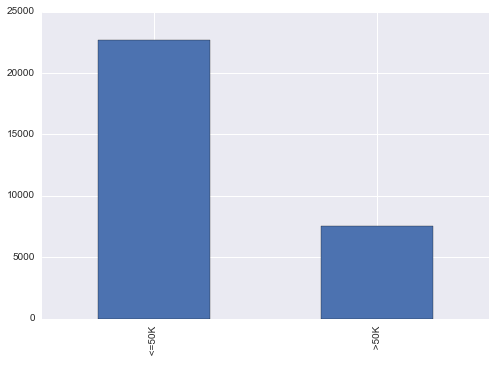

In [14]:
# check to see if target is balanced
train['class'].value_counts().plot('bar')

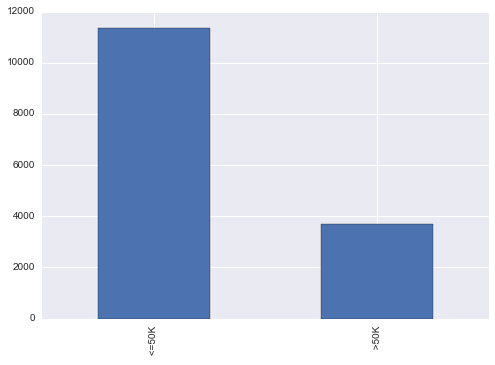

In [15]:
test['class'].value_counts().plot('bar')

## Data Analysis

In [16]:
# converting into arrays
train_arr = train.as_matrix()
test_arr = test.copy().as_matrix()

In [17]:
# extracting target from test data and setting the values in test mat to NaNs (needed for prediction)
test_Y = test_arr.copy()[:,-1]
test_arr[:,-1] = np.array([np.nan]*len(test['class']))

In [18]:
# create a bayesian network using training data
%time model_exact = BayesianNetwork.from_samples(train_arr, algorithm='exact') # using exact net

CPU times: user 2min 27s, sys: 50.3 s, total: 3min 17s
Wall time: 3min 27s


In [19]:
%time model_chow = BayesianNetwork.from_samples(train_arr, algorithm='chow-liu') # using chow-liu trees

CPU times: user 1.73 s, sys: 17.3 ms, total: 1.74 s
Wall time: 1.88 s


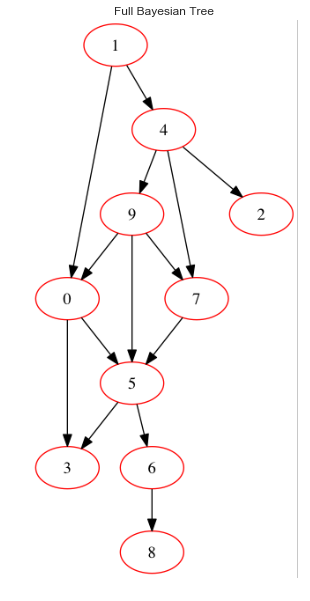

In [20]:
# visualize the networks
# full network
plt.figure(figsize=(14, 10))
model_exact.plot()
plt.title('Full Bayesian Tree')
plt.show()

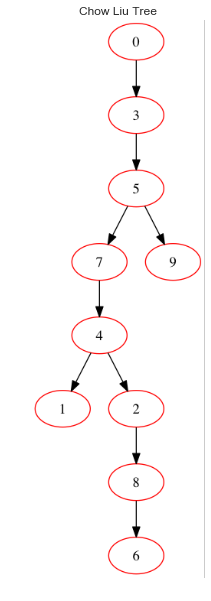

In [21]:
# chow-liu tree
plt.figure(figsize=(14, 10))
model_chow.plot()
plt.title('Chow Liu Tree')
plt.show()

Income category ("class") is our target, and we use the trees that have been constructed to predict this variable

In [22]:
%time test_exact_preds = model_exact.predict(test_arr)

CPU times: user 2min 32s, sys: 910 ms, total: 2min 33s
Wall time: 2min 33s


In [23]:
%time test_chow_preds = model_chow.predict(test_arr)

CPU times: user 2min 9s, sys: 1.01 s, total: 2min 10s
Wall time: 2min 10s


In [24]:
# calculate accuracy
# exact implementation
exact_acc = float(sum(test_exact_preds[:,-1] == test_Y))/len(test_Y)
print('The accuracy of the exact bayesian network is ',exact_acc)

The accuracy of the exact bayesian network is  0.8167994687915007


In [25]:
# chow implementation
chow_acc = float(sum(test_chow_preds[:,-1] == test_Y))/len(test_Y)
print('The accuracy of the exact bayesian network is ',chow_acc)

The accuracy of the exact bayesian network is  0.7543160690571049
